In [ ]:
from getpass import getpass

admin_rdm_url = 'https://admin.bh.rdm.yzwlab.com/' #'https://admin.staging.rdm.example.com/'
idp_name_1 = None # 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
default_result_path = None
close_on_fail = False
transition_timeout = 30000

In [2]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

(7, 16)

# 定期監視-管理者-利用統計

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン
- シナリオ名: ログイン確認
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)
- 備考: https://bitbucket.org/osf_japan/operations/src/master/ARI/%E9%81%8B%E7%94%A8%E6%89%8B%E9%A0%86%E6%9B%B8/%E7%9B%A3%E8%A6%96/%E8%BF%BD%E5%8A%A0%E7%9B%A3%E8%A6%96_%E7%AE%A1%E7%90%86%E8%80%85%E7%94%BB%E9%9D%A2%E3%83%AD%E3%82%B0%E3%82%A4%E3%83%B3%E7%A2%BA%E8%AA%8D.md

## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。

③ブラウザを開き、下記URLにアクセスする。  
https://rdm.example.com/  

In [3]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmp22h6gctm'

In [4]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20251117-044343', '/tmp/tmp5n__rgmn')

Start epoch: 1763354623.4998045 seconds


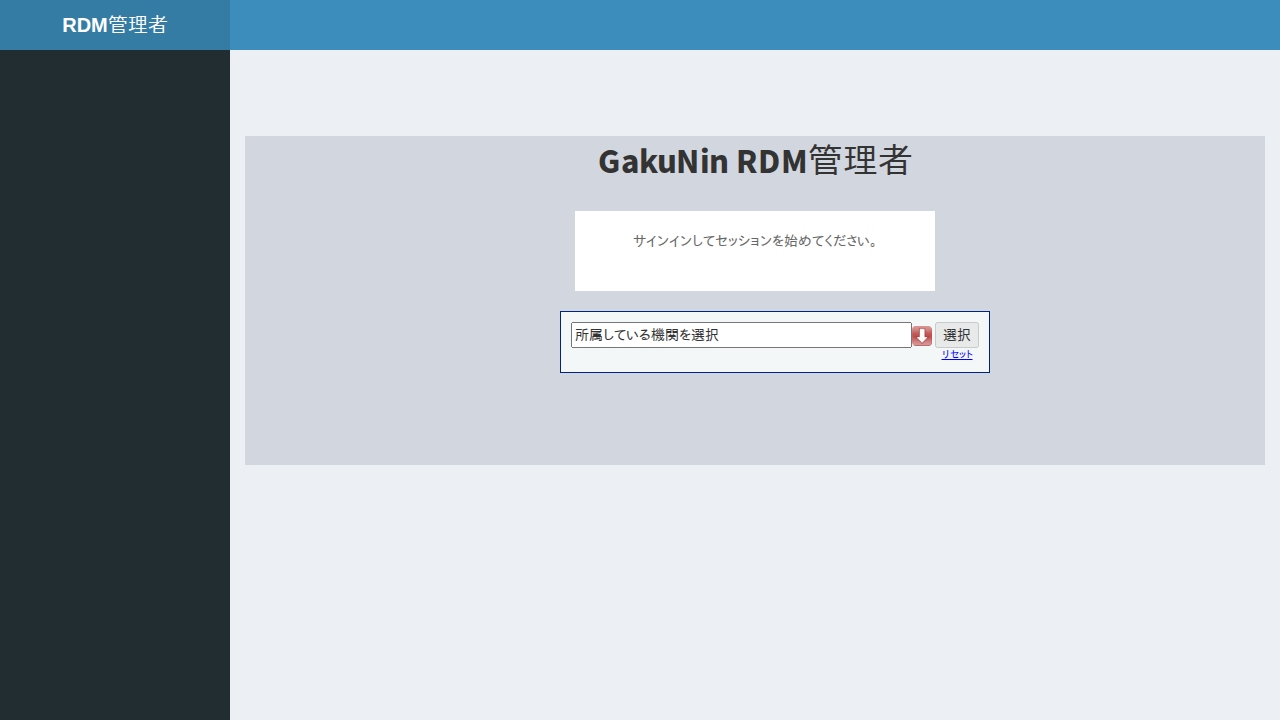

In [5]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1763354625.7880802 seconds
ierae08
YibkH0U9-3^%Z@v8


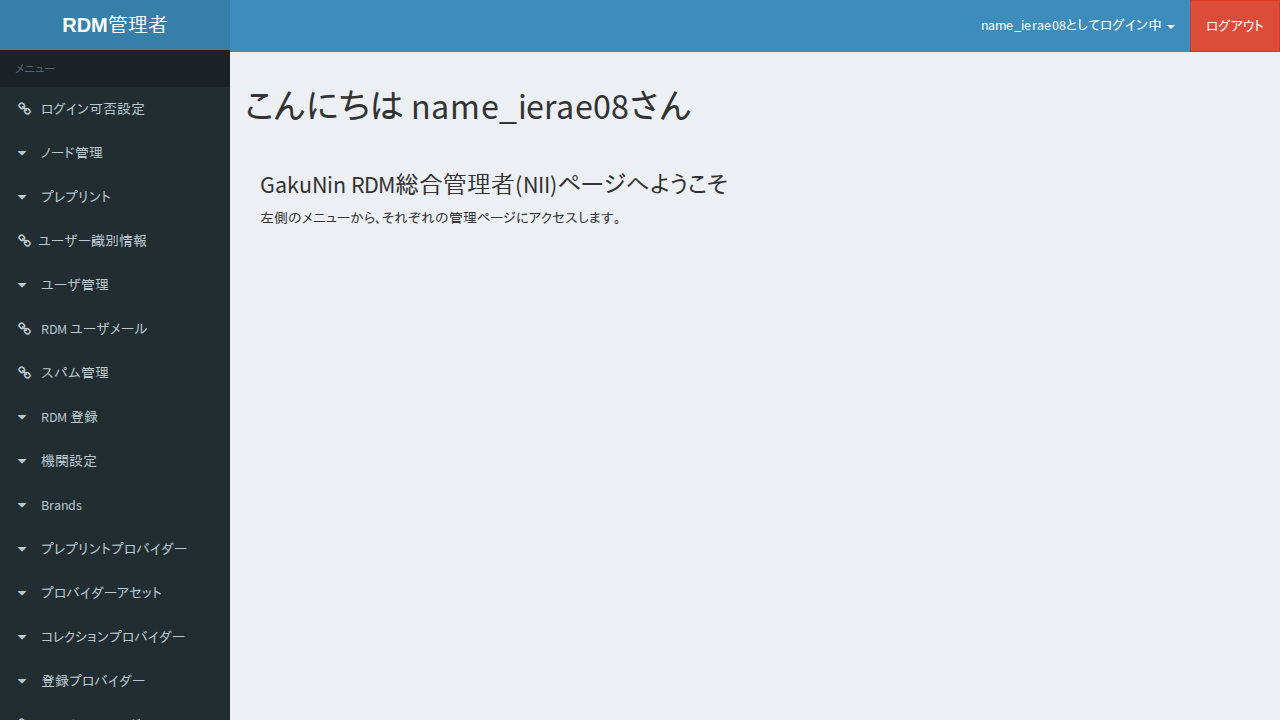

In [6]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login_as_admin(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await expect(page.locator('//*[contains(@class, "btn-danger") and contains(text(), "ログアウト")]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「利用統計」を選択する



Start epoch: 1763354633.0813994 seconds


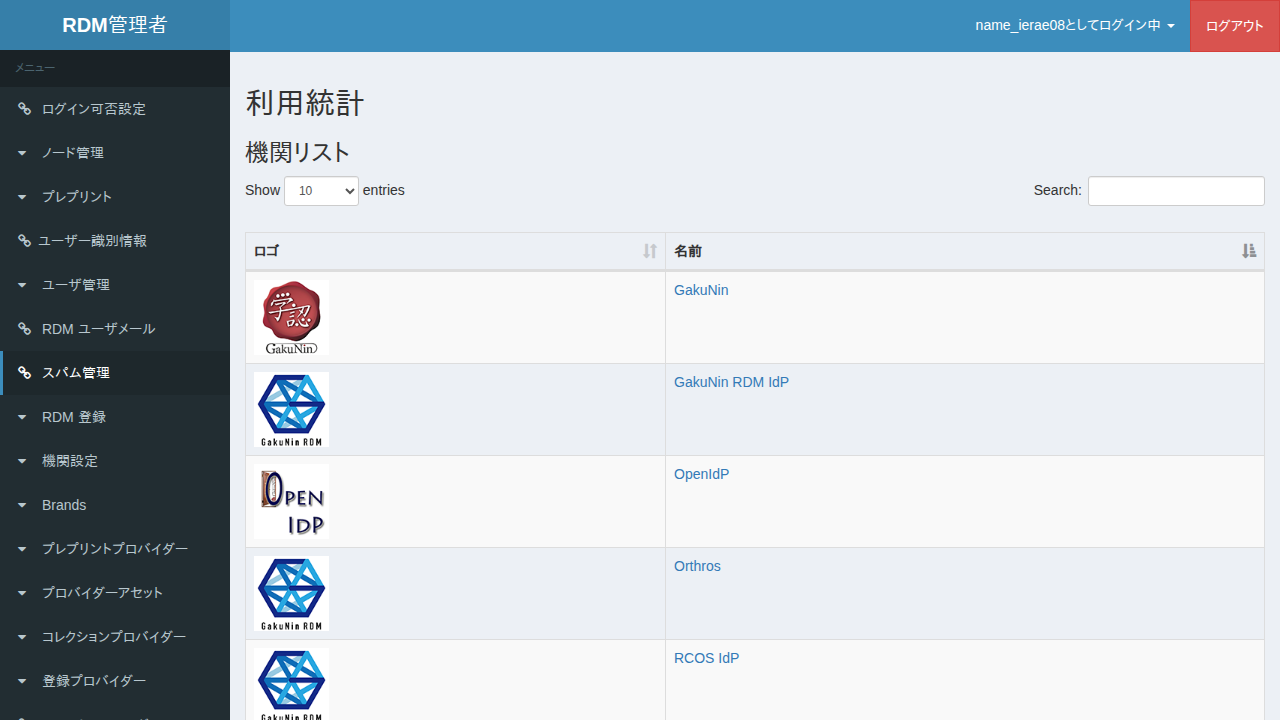

In [7]:
async def _step(page):
    await page.locator('//a[@href = "/statistics/"]').click(timeout=transition_timeout * 5)

    #await expect(page.locator('//*[text() = "PDFダウンロード"]')).to_be_enabled(timeout=transition_timeout * 5)
    await expect(page.locator('//input[@type = "search"]')).to_be_visible(timeout=transition_timeout * 5)

await run_pw(_step)

## 機関リストの名前欄にある「GakuNin RDM IdP」をクリックする

Start epoch: 1763354633.5904658 seconds


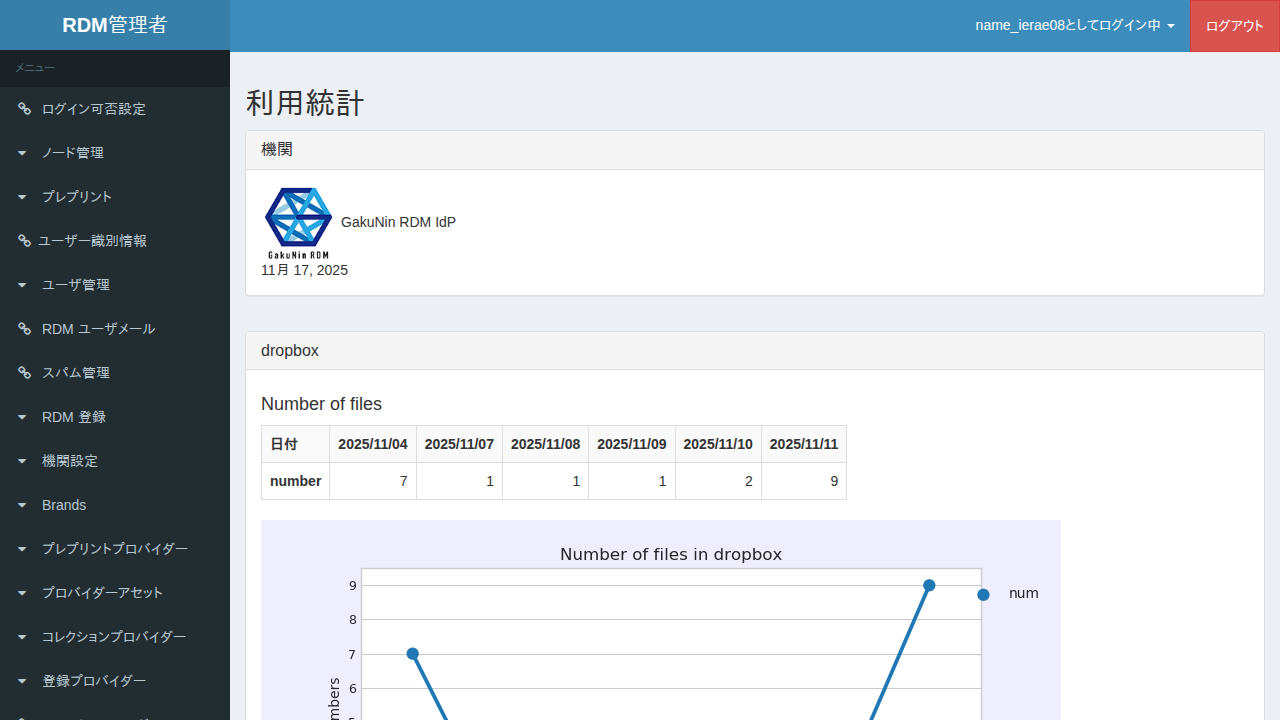

In [8]:
target_organization = 'GakuNin RDM IdP'

async def _step(page):
    await page.locator('//input[@type = "search"]').fill(target_organization)

    organization_link = page.locator(f'//a[contains(text(), "{target_organization}")]')
    await expect(organization_link).to_be_visible()
    await organization_link.click(timeout=transition_timeout * 5)
    time.sleep(30)
    await expect(page.locator('//*[text() = "PDFダウンロード"]')).to_be_enabled(timeout=transition_timeout * 5)

await run_pw(_step)

## 「PDFダウンロード」ボタンを押下する

Start epoch: 1763354699.8112254 seconds


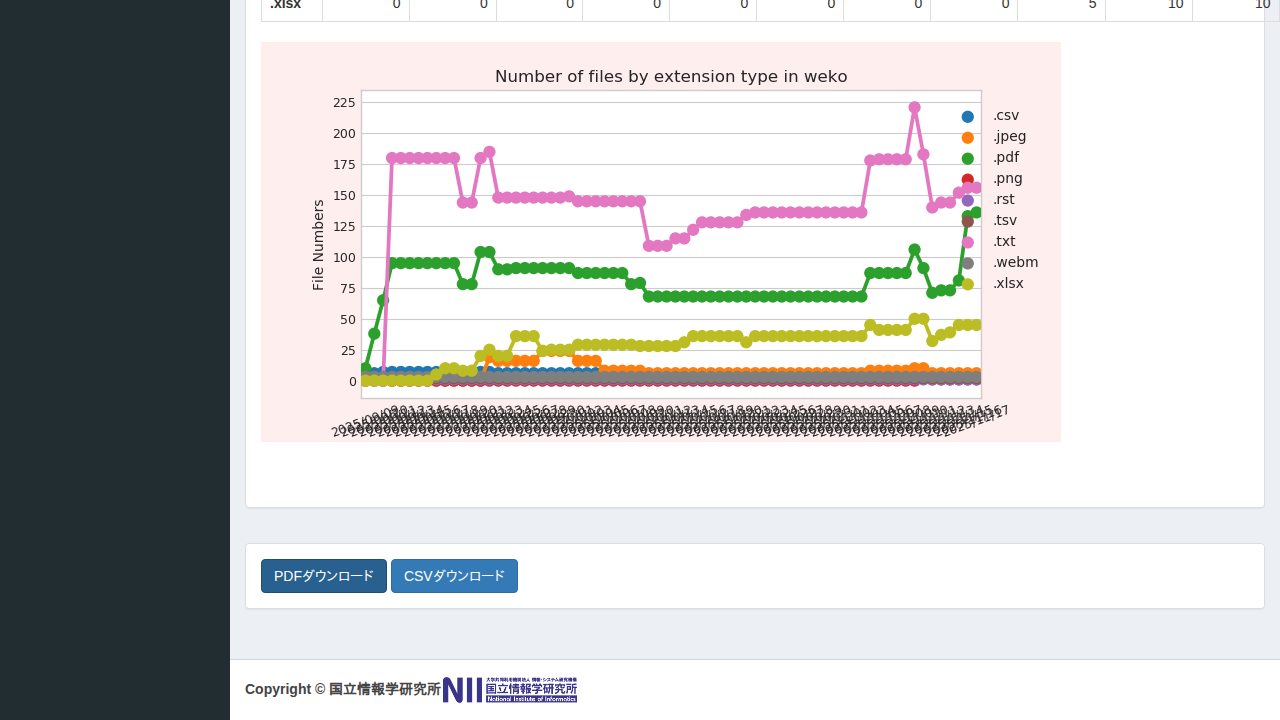

In [9]:
async def _step(page):
    async with page.expect_download(timeout=transition_timeout * 5) as download_info:
        await page.locator('//*[text() = "PDFダウンロード"]').click(timeout=transition_timeout * 5)
    download = await download_info.value
    download_dir = os.path.join(work_dir, 'downloaded')
    os.makedirs(download_dir, exist_ok=True)
    download_path = os.path.join(download_dir, download.suggested_filename)
    await download.save_as(download_path)
    await page.locator('//*[text() = "PDFダウンロード"]').scroll_into_view_if_needed()

await run_pw(_step)

In [10]:
!ls -la {work_dir}/downloaded

total 1476
drwxr-xr-x 2 jovyan users      37 Nov 17 04:46 .
drwx------ 3 jovyan users      24 Nov 17 04:46 ..
-rw-r--r-- 1 jovyan users 1511132 Nov 17 04:46 statistics.20251117.pdf


In [11]:
!rm {work_dir}/downloaded/*

## 「CSVダウンロード」ボタンを押下する

Start epoch: 1763354792.0375023 seconds


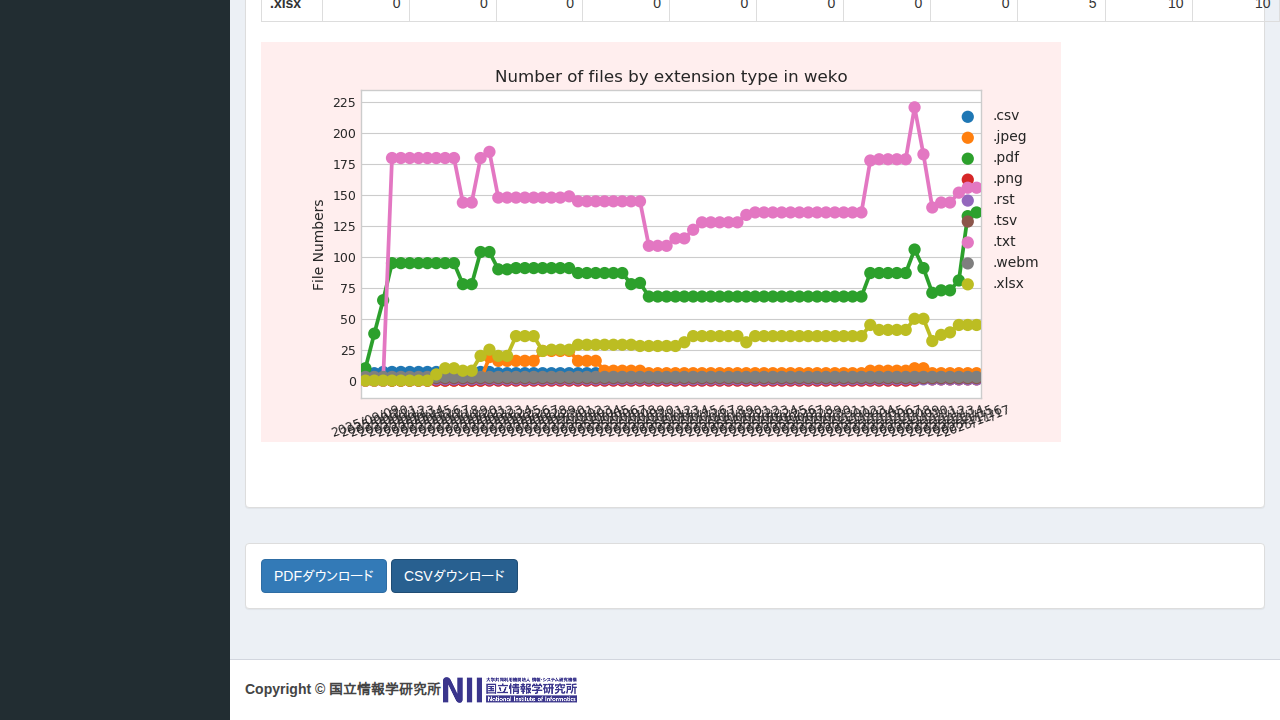

In [12]:
async def _step(page):
    async with page.expect_download(timeout=transition_timeout * 5) as download_info:
        await page.locator('//*[text() = "CSVダウンロード"]').click(timeout=transition_timeout * 5)
    download = await download_info.value
    download_dir = os.path.join(work_dir, 'downloaded')
    os.makedirs(download_dir, exist_ok=True)
    download_path = os.path.join(download_dir, download.suggested_filename)
    await download.save_as(download_path)

await run_pw(_step)

In [13]:
!ls -la {work_dir}/downloaded

total 2552
drwxr-xr-x 2 jovyan users      41 Nov 17 04:46 .
drwx------ 3 jovyan users      24 Nov 17 04:46 ..
-rw-r--r-- 1 jovyan users 2612912 Nov 17 04:46 statistics.all.20251117.csv


終了処理を実施。

In [14]:
await finish_pw_context()

Video: result/result-20251117-041029/取りまとめ-管理者機能/notebooks/テスト手順-管理者機能-利用統計/video-1.webm
HAR: result/result-20251117-041029/取りまとめ-管理者機能/notebooks/テスト手順-管理者機能-利用統計/har.zip


スクリーンキャプチャ動画の取得に失敗しました。
Traceback (most recent call last):
  File "/home/jovyan/scripts/playwright.py", line 168, in _finish_pw_context
    shutil.copyfile(video_path, dest_video_path)
  File "/opt/conda/lib/python3.12/shutil.py", line 260, in copyfile
    with open(src, 'rb') as fsrc:
         ^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmp5n__rgmn/videos/590914bcc26a56e2f72865ae0244cadc.webm'


In [15]:
!rm -fr {work_dir}